# Magnitudes to Fluxes and vice versa

**@juliaroquette@19Dec2023**: In this version I am now using mainly a clone of the SVO database to get the zeropoints. Here I have done this clonning and I am now in process of filling in a `my_id_to_SVO` dictionary which correlates labels on my SED catalogue with the SVO ones. 

What has already been translated:
- Spitzer IRAC/MIPS
- 2MASS
- WISE
- Gaia DR3
- Johnson
- Cousins
- WHT/INGRID
- UKIRT/UKIDS
- Sloan/SDSS
- VISTA & VISION
- GALEX FUV/NUV
- DENIS
- UCAC4: has Johnson-Cousins (Landolt) BVRc, and gri from sdss
- MKO
- APEX
- TYCHO
- ISO
- Gemini/TReCs
- HST F139
- Herschel PACS

TO DO:
- Download transmission curves.
- re-write transmission curve class
- ADD UKIRT MAX NQ
- deal with AB fluxes
- add:
    - tess
    - aca 
    - wircam w
    eso mpi/mpg
    panstarrs

- ESO 2.2m MPI/WFI
- CTIO/Decam Sloan ugriz, ukidss Y
- VLT FORS1 u_high
- CMC
- INT/WFC


**References**:

- [SVO calculation notes](https://www.ivoa.net/documents/Notes/SVOFPS/NOTE-SVOFPS-1.0.20121015.pdf)
- [astroquery.svo_fps](https://astroquery.readthedocs.io/en/latest/svo_fps/svo_fps.html#)
- [SVO webpage](http://svo2.cab.inta-csic.es/svo/theory/fps/)

- Zero Points are given in Jy
- $\lambda_\mathrm{eff}$ are given in $\AA$




In [52]:
import numpy as np
import csv
from NEMESIS.sed_NEMESIS.scr.SED_builder import zeropoints, mag2flux, flux2mag
from astropy import units as u
from astropy import constants as const
import matplotlib.pyplot as plt
from matplotlib import colors
from astroquery.svo_fps import SvoFps
import pandas as pd

In [53]:
my_dir = '/Users/juliaroquette/Work/Data/SED_builder/'

# using SvoFps

In [4]:
filter_key = '2MASS/2MASS.Ks'
transmission_curve = SvoFps.get_transmission_data(filter_key)

In [24]:
SVO_database = SvoFps.get_filter_index(1_000*u.angstrom, 2_000*u.angstrom)

In [25]:
"['FilterProfileService', 'filterID', 'WavelengthUnit', 'WavelengthUCD', 'PhotSystem', 'DetectorType', 'Band', 'Instrument', 'Facility', 'ProfileReference', 'CalibrationReference', 'Description', 'Comments', 'WavelengthRef', 'WavelengthMean', 'WavelengthEff', 'WavelengthMin', 'WavelengthMax', 'WidthEff', 'WavelengthCen', 'WavelengthPivot', 'WavelengthPeak', 'WavelengthPhot', 'FWHM', 'Fsun', 'PhotCalID', 'MagSys', 'ZeroPoint', 'ZeroPointUnit', 'Mag0', 'ZeroPointType', 'AsinhSoft', 'TrasmissionCurve']"

"['FilterProfileService', 'filterID', 'WavelengthUnit', 'WavelengthUCD', 'PhotSystem', 'DetectorType', 'Band', 'Instrument', 'Facility', 'ProfileReference', 'CalibrationReference', 'Description', 'Comments', 'WavelengthRef', 'WavelengthMean', 'WavelengthEff', 'WavelengthMin', 'WavelengthMax', 'WidthEff', 'WavelengthCen', 'WavelengthPivot', 'WavelengthPeak', 'WavelengthPhot', 'FWHM', 'Fsun', 'PhotCalID', 'MagSys', 'ZeroPoint', 'ZeroPointUnit', 'Mag0', 'ZeroPointType', 'AsinhSoft', 'TrasmissionCurve']"

In [142]:
test = SvoFps.get_filter_index(3650*u.angstrom, 3660*u.angstrom).to_pandas()

In [153]:
test.loc[3, 'Facility']

''

In [135]:
SvoFps.get_filter_list(facility='')

FilterProfileService,filterID,WavelengthUnit,WavelengthUCD,PhotSystem,DetectorType,Band,Instrument,Facility,ProfileReference,CalibrationReference,Description,Comments,WavelengthRef,WavelengthMean,WavelengthEff,WavelengthMin,WavelengthMax,WidthEff,WavelengthCen,WavelengthPivot,WavelengthPeak,WavelengthPhot,FWHM,Fsun,PhotCalID,MagSys,ZeroPoint,ZeroPointUnit,Mag0,ZeroPointType,AsinhSoft,TrasmissionCurve
,,,,,,,,,,,,,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,erg / (A s cm2),,,Jy,,,,,
object,object,object,object,object,object,object,object,object,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,object,float64,object,float64,object


# Creating a database of relevant filters

In [199]:
my_id_to_SVO = {}
calib_system = {}

### Cloning SVO for the range 0.1-1000 $\mu m$ (1000-10000000 $\AA$)

In [160]:
svo_database = pd.DataFrame()
limit = [1e3, 2.5e3, 5e3, 6e3, 7e3, 8e3, 9e3, 1e4, 5e4, 1e5, 1e6, 1e7, 1e8]
for i in range(len(limit)-1):
    print(limit[i], limit[i+1])
    svo_output = SvoFps.get_filter_index(limit[i]*u.angstrom, limit[i+1]*u.angstrom).to_pandas()
    svo_database = pd.concat([svo_database, svo_output])

1000.0 2500.0
2500.0 5000.0
5000.0 6000.0
6000.0 7000.0
7000.0 8000.0
8000.0 9000.0
9000.0 10000.0
10000.0 50000.0
50000.0 100000.0
100000.0 1000000.0
1000000.0 10000000.0
10000000.0 100000000.0


In [161]:
svo_database.shape

(10672, 33)

In [162]:
svo_database.to_csv(my_dir+'svo_database.csv')

In [163]:
svo_database.head()

,FilterProfileService,filterID,WavelengthUnit,WavelengthUCD,PhotSystem,DetectorType,Band,Instrument,Facility,ProfileReference,...,FWHM,Fsun,PhotCalID,MagSys,ZeroPoint,ZeroPointUnit,Mag0,ZeroPointType,AsinhSoft,TrasmissionCurve
0,ivo://svo/fps,HST/STIS_FUV.F25LYA,Angstrom,em.wl,STIS-FUV,1,,STIS,HST,https://stsynphot.readthedocs.io/en/latest/sts...,...,80.635276,0.000000,HST/STIS_FUV.F25LYA/Vega,Vega,51.667263,Jy,0.0,,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
1,ivo://svo/fps,HST/STIS_FUV.F25LYA_G140L,Angstrom,em.wl,STIS-FUV,1,,STIS,HST,https://stsynphot.readthedocs.io/en/latest/sts...,...,99.157589,0.000000,HST/STIS_FUV.F25LYA_G140L/Vega,Vega,56.199768,Jy,0.0,,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
2,ivo://svo/fps,HST/STIS_FUV.F25LYA_G140M,Angstrom,em.wl,STIS-FUV,1,,STIS,HST,https://stsynphot.readthedocs.io/en/latest/sts...,...,95.244766,0.000000,HST/STIS_FUV.F25LYA_G140M/Vega,Vega,55.619713,Jy,0.0,,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
3,ivo://svo/fps,IUE/IUE.1250-1300,Angstrom,em.wl,IUE,0,,,IUE,,...,51.000000,0.003629,IUE/IUE.1250-1300/Vega,Vega,80.297383,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
4,ivo://svo/fps,HST/ACS_SBC.F122M,Angstrom,em.wl,ACS-SBC,1,,ACS,HST,https://stsynphot.readthedocs.io/en/latest/sts...,...,101.499535,0.000000,HST/ACS_SBC.F122M/Vega,Vega,91.667816,Jy,0.0,,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...


In [165]:
len(svo_database.filterID.unique())

10672

In [166]:
svo_database.set_index('filterID', inplace=True)
svo_database.to_csv(my_dir+'svo_database.csv')

## Spizter IRAC and MIPS

-> Vega

In [200]:
calib_system['irac_1'] = 'Vega'
calib_system['irac_2'] = 'Vega'
calib_system['irac_3'] = 'Vega'
calib_system['irac_1'] = 'Vega'
calib_system['irac_2'] = 'Vega'
calib_system['irac_3'] = 'Vega'
calib_system['irac_4'] = 'Vega'
calib_system['mips_1'] = 'Vega'
calib_system['mips_2'] = 'Vega' 
calib_system['mips_3'] = 'Vega'
calib_system['mips_1'] = 'Vega'
calib_system['mips_2'] = 'Vega' 
calib_system['mips_3'] = 'Vega'

In [167]:
my_id_to_SVO['irac_1'] = 'Spitzer/IRAC.I1'
my_id_to_SVO['irac_2'] = 'Spitzer/IRAC.I3'
my_id_to_SVO['irac_3'] = 'Spitzer/IRAC.I3'
my_id_to_SVO['irac_4'] = 'Spitzer/IRAC.I4'
my_id_to_SVO['mips_1'] = 'Spitzer/MIPS.24mu'
my_id_to_SVO['mips_2'] = 'Spitzer/MIPS.70mu' 
my_id_to_SVO['mips_3'] = 'Spitzer/MIPS.160mu'

In [168]:
svo_database.loc[my_id_to_SVO['irac_1'], 'ZeroPoint']

274.53023426553

## 2MASS:

Source: http://svo2.cab.inta-csic.es/svo/theory/fps/index.php?mode=browse&gname=2MASS&asttype=
-> https://iopscience.iop.org/article/10.1086/376474/pdf 

Tab 2
-> Vega

In [201]:
for k in ['twomass_J', 'twomass_H', 'twomass_Ks']: 
    calib_system[k] = 'Vega'

In [202]:
my_id_to_SVO['twomass_J'] = '2MASS/2MASS.J'
my_id_to_SVO['twomass_H'] = '2MASS/2MASS.H'
my_id_to_SVO['twomass_Ks'] = '2MASS/2MASS.Ks'

## AllWISE:
source: http://svo2.cab.inta-csic.es/svo/theory/fps/index.php?mode=browse&gname=WISE&asttype=

https://wise2.ipac.caltech.edu/docs/release/prelim/expsup/sec4_3g.html#WISEZMA Tab4

-> Vega

In [203]:
for k in ['allwise_w1', 'allwise_w2', 'allwise_w3', 'allwise_w4']:
    calib_system[k] = 'Vega'

In [204]:
my_id_to_SVO['allwise_1'] = 'WISE/WISE.W1'
my_id_to_SVO['allwise_2'] = 'WISE/WISE.W3'
my_id_to_SVO['allwise_3'] = 'WISE/WISE.W3'
my_id_to_SVO['allwise_4'] = 'WISE/WISE.W4'

## Gaia DR3
source: http://svo2.cab.inta-csic.es/svo/theory/fps/index.php?mode=browse&gname=GAIA&gname2=GAIA3&asttype=

-> Vega magnitude system

In [205]:
for k in ['gaiaDR3_G', 'gaiaDR3_BP', 'gaiaDR3_RP']:
    calib_system[k] = 'Vega'

In [206]:
my_id_to_SVO['gaiaDR3_BP'] = 'GAIA/GAIA3.Gbp'
my_id_to_SVO['gaiaDR3_RP'] = 'GAIA/GAIA3.G'
my_id_to_SVO['gaiaDR3_G'] = 'GAIA/GAIA3.Grp'

## Generic: Bessel and Johnson-Cousins
source: http://svo2.cab.inta-csic.es/svo/theory/fps/index.php?mode=browse&gname=Generic&asttype=

Bessel will typically be on Vega magnitudes

Vizier SED META Call Besselll filters UX VX BVRI and report parameters from ADPS2, though it doesn't give the zeropoints.
These filters are bit funny though, and I am not sure who uses them, I think Bessel was more towards defining the Visual magnitude V that our eyes see. 

### Bessell filters

In [181]:
svo_database[svo_database.index.str.contains('bessell', case=False)]

,FilterProfileService,WavelengthUnit,WavelengthUCD,PhotSystem,DetectorType,Band,Instrument,Facility,ProfileReference,CalibrationReference,...,FWHM,Fsun,PhotCalID,MagSys,ZeroPoint,ZeroPointUnit,Mag0,ZeroPointType,AsinhSoft,TrasmissionCurve
filterID,,,,,,,,,,,,,,,,,,,,,
Generic/Bessell.U,ivo://svo/fps,Angstrom,em.wl,Bessell,0,U,,,,,...,652.838404,107.026497,Generic/Bessell.U/Vega,Vega,1699.710473,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
CTIO/Goodman.U_Bessell,ivo://svo/fps,Angstrom,em.wl,Goodman,1,,Goodman,CTIO,https://noirlab.edu/science/filters,,...,600.124458,105.079220,CTIO/Goodman.U_Bessell/Vega,Vega,1794.078244,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
OAF/Bessell.U,ivo://svo/fps,Angstrom,em.wl,Bessell,0,U,,OAF,,,...,503.057578,110.004818,OAF/Bessell.U/Vega,Vega,1797.947588,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
HCT/HFOSC.Bessell_U,ivo://svo/fps,Angstrom,em.wl,HFOSC,1,U,HFOSC,HCT,https://www.iiap.res.in/iao/hfosc.html,,...,489.952418,115.621013,HCT/HFOSC.Bessell_U/Vega,Vega,1773.532967,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
OAF/Bessell.B,ivo://svo/fps,Angstrom,em.wl,Bessell,0,B,,OAF,,,...,926.462704,167.369734,OAF/Bessell.B/Vega,Vega,3652.811179,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
LCO/IMACS.Bessell_B1,ivo://svo/fps,Angstrom,em.wl,IMACS,0,B,IMACS,LCO,http://www.lco.cl/telescopes-information/magel...,,...,1071.117647,170.564831,LCO/IMACS.Bessell_B1/Vega,Vega,3837.794271,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
LCO/IMACS.Bessell_B2,ivo://svo/fps,Angstrom,em.wl,IMACS,0,B,IMACS,LCO,http://www.lco.cl/telescopes-information/magel...,,...,1082.843846,171.010081,LCO/IMACS.Bessell_B2/Vega,Vega,3884.113868,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
CTIO/Goodman.B_Bessell,ivo://svo/fps,Angstrom,em.wl,Goodman,1,,Goodman,CTIO,https://noirlab.edu/science/filters,,...,990.251547,174.433708,CTIO/Goodman.B_Bessell/Vega,Vega,3965.484379,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
Generic/Bessell.B,ivo://svo/fps,Angstrom,em.wl,Bessell,0,B,,,,,...,947.616298,176.673349,Generic/Bessell.B/Vega,Vega,3908.458985,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...


In [207]:
for k in ['bessel_U', 'bessel_B', 'bessel_V', 'bessel_R', 'bessel_I']:
    calib_system[k] = 'Vega'

In [182]:
my_id_to_SVO['bessell_U'] = 'Generic/Bessell.U'
my_id_to_SVO['bessell_B'] = 'Generic/Bessell.B'
my_id_to_SVO['bessell_V'] = 'Generic/Bessell.V'
my_id_to_SVO['bessell_R'] = 'Generic/Bessell.R'
my_id_to_SVO['bessell_I'] = 'Generic/Bessell.I'

### cousins

Source: SVO: http://svo2.cab.inta-csic.es/svo/theory/fps/index.php?mode=browse&gname=Generic&gname2=Cousins&asttype=


In [209]:
for k in ['cousins_Rc', 'cousins_Ic']:
    calib_system[k] = 'Vega'

In [183]:
svo_database[svo_database.index.str.contains('cousins', case=False)]

,FilterProfileService,WavelengthUnit,WavelengthUCD,PhotSystem,DetectorType,Band,Instrument,Facility,ProfileReference,CalibrationReference,...,FWHM,Fsun,PhotCalID,MagSys,ZeroPoint,ZeroPointUnit,Mag0,ZeroPointType,AsinhSoft,TrasmissionCurve
filterID,,,,,,,,,,,,,,,,,,,,,
GCPD/Cousins.R_ADPS,ivo://svo/fps,Angstrom,em.wl,Cousins,0,R,,,http://obswww.unige.ch/gcpd/system.html,,...,1516.486486,160.377323,GCPD/Cousins.R_ADPS/Vega,Vega,3072.828711,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
Generic/Cousins.R,ivo://svo/fps,Angstrom,em.wl,Cousins,0,R,,,http://ulisse.pd.astro.it/Astro/ADPS/Systems/S...,,...,1516.486486,160.377323,Generic/Cousins.R/Vega,Vega,3072.828711,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
OSN/Circ.Cousins_R,ivo://svo/fps,Angstrom,em.wl,Cousins,0,R,,OSN,http://www.osn.iaa.es/content/available-filters,,...,1519.326332,156.634371,OSN/Circ.Cousins_R/Vega,Vega,3051.829782,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
GCPD/Cousins.R,ivo://svo/fps,Angstrom,em.wl,Cousins,0,R,,,http://arxiv.org/abs/1412.1474,http://arxiv.org/abs/1412.1474,...,1671.251518,155.685793,GCPD/Cousins.R/Vega,Vega,3032.505148,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
Scorpio/Cousins.Rc,ivo://svo/fps,Angstrom,em.wl,Cousins,0,R,,Scorpio,https://www.sao.ru/hq/lsfvo/devices/scorpio/sc...,,...,1495.522895,155.661888,Scorpio/Cousins.Rc/Vega,Vega,3035.490439,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
OSN/Johnson.Cousins_R2,ivo://svo/fps,Angstrom,em.wl,Cousins,0,R,,OSN,http://www.osn.iaa.es/content/available-filters,,...,1468.563686,155.555975,OSN/Johnson.Cousins_R2/Vega,Vega,3027.955586,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
OSN/Johnson.Cousins_R3,ivo://svo/fps,Angstrom,em.wl,Cousins,1,R,,OSN,http://www.osn.iaa.es/en/page/available-filters,,...,1699.991594,154.274894,OSN/Johnson.Cousins_R3/Vega,Vega,3021.273805,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
OSN/Johnson.Cousins_R1,ivo://svo/fps,Angstrom,em.wl,Cousins,1,R,,OSN,http://www.osn.iaa.es/en/page/available-filters,,...,1692.474094,154.014872,OSN/Johnson.Cousins_R1/Vega,Vega,3017.040400,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
GCPD/Cousins.I_ADPS,ivo://svo/fps,Angstrom,em.wl,Cousins,0,I,,,http://obswww.unige.ch/gcpd/system.html,,...,1093.669355,116.571292,GCPD/Cousins.I_ADPS/Vega,Vega,2452.012658,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...


In [184]:
my_id_to_SVO['cousins_Rc'] = 'Generic/Cousins.R'
my_id_to_SVO['cousins_Ic'] = 'Generic/Cousins.I'

### Johnson

In [188]:
svo_database[svo_database.index.str.contains('johnson', case=False) & svo_database.index.str.contains('R', case=True)]


,FilterProfileService,WavelengthUnit,WavelengthUCD,PhotSystem,DetectorType,Band,Instrument,Facility,ProfileReference,CalibrationReference,...,FWHM,Fsun,PhotCalID,MagSys,ZeroPoint,ZeroPointUnit,Mag0,ZeroPointType,AsinhSoft,TrasmissionCurve
filterID,,,,,,,,,,,,,,,,,,,,,
Generic/Johnson_UBVRIJHKL.U,ivo://svo/fps,Angstrom,em.wl,Johnson_UBVRIJHKL,0,U,,,http://adsabs.harvard.edu/abs/1968ApJ...152..465J,,...,683.730790,106.002784,Generic/Johnson_UBVRIJHKL.U/Vega,Vega,1438.731285,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
Generic/Johnson_UBVRIJHKL.B,ivo://svo/fps,Angstrom,em.wl,Johnson_UBVRIJHKL,0,B,,,http://adsabs.harvard.edu/abs/1968ApJ...152..465J,,...,1011.111111,184.998766,Generic/Johnson_UBVRIJHKL.B/Vega,Vega,4318.321722,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
Generic/Johnson_UBVRIJHKL.V,ivo://svo/fps,Angstrom,em.wl,Johnson_UBVRIJHKL,0,V,,,http://adsabs.harvard.edu/abs/1968ApJ...152..465J,,...,876.672384,181.953525,Generic/Johnson_UBVRIJHKL.V/Vega,Vega,3617.503147,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
GCPD/Johnson.R_Landolt,ivo://svo/fps,Angstrom,em.wl,Johnson,0,R,,,http://ulisse.pd.astro.it/Astro/ADPS/Systems/S...,,...,1580.467969,158.076164,GCPD/Johnson.R_Landolt/Vega,Vega,3081.623341,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
CAHA/LAICA.Johnson_R,ivo://svo/fps,Angstrom,em.wl,LAICA,0,R,LAICA,CAHA,http://www.caha.es/CAHA/Instruments/LAICA/manu...,,...,1866.854839,155.263013,CAHA/LAICA.Johnson_R/Vega,Vega,3029.897386,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
OSN/Johnson.Cousins_R2,ivo://svo/fps,Angstrom,em.wl,Cousins,0,R,,OSN,http://www.osn.iaa.es/content/available-filters,,...,1468.563686,155.555975,OSN/Johnson.Cousins_R2/Vega,Vega,3027.955586,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
OSN/Johnson.Cousins_R3,ivo://svo/fps,Angstrom,em.wl,Cousins,1,R,,OSN,http://www.osn.iaa.es/en/page/available-filters,,...,1699.991594,154.274894,OSN/Johnson.Cousins_R3/Vega,Vega,3021.273805,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
OSN/Johnson.Cousins_R1,ivo://svo/fps,Angstrom,em.wl,Cousins,1,R,,OSN,http://www.osn.iaa.es/en/page/available-filters,,...,1692.474094,154.014872,OSN/Johnson.Cousins_R1/Vega,Vega,3017.040400,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
GCPD/Johnson.R_Mendoza,ivo://svo/fps,Angstrom,em.wl,Johnson,0,R,,,http://obswww.unige.ch/gcpd/system.html,,...,2087.500000,145.588159,GCPD/Johnson.R_Mendoza/Vega,Vega,2906.540808,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...


In [210]:
for k in ['johnson_U', 'johnson_B', 'johnson_V', 'johnson_R', 'johnson_I', 'johnson_J', 'johnson_H', 'johnson_K', 'johnson_LI', 'johnson_LII', 'johnson_M' 'johnson_N',]:
    calib_system[k] = 'Vega'

In [211]:
my_id_to_SVO['johnson_U'] = 'Generic/Johnson.U'
my_id_to_SVO['johnson_B'] = 'Generic/Johnson.B'
my_id_to_SVO['johnson_V'] = 'Generic/Johnson.V'
my_id_to_SVO['johnson_R'] = 'Generic/Johnson.R'
my_id_to_SVO['johnson_I'] = 'Generic/Johnson.I'
my_id_to_SVO['johnson_J'] = 'Johnson_UBVRIJHKL.J'
my_id_to_SVO['johnson_H'] = 'Johnson_UBVRIJHKL.H'
my_id_to_SVO['johnson_K'] = 'Johnson_UBVRIJHKL.K'
my_id_to_SVO['johnson_LI'] ='Johnson_UBVRIJHKL.LI'
my_id_to_SVO['johnson_LII'] = 'Johnson_UBVRIJHKL.LII'
my_id_to_SVO['johnson_M'] = 'Generic/Johnson.M'
my_id_to_SVO['johnson_N'] ='Generic/Johnson_UBVRIJHKL.N'

## CFHT

#### MOCAM

In [192]:
svo_database[svo_database.index.str.contains('mocam', case=False)]

,FilterProfileService,WavelengthUnit,WavelengthUCD,PhotSystem,DetectorType,Band,Instrument,Facility,ProfileReference,CalibrationReference,...,FWHM,Fsun,PhotCalID,MagSys,ZeroPoint,ZeroPointUnit,Mag0,ZeroPointType,AsinhSoft,TrasmissionCurve
filterID,,,,,,,,,,,,,,,,,,,,,
CFHT/MOCAM.B,ivo://svo/fps,Angstrom,em.wl,MOCAM,0,B,MOCAM,CFHT,http://cfht.hawaii.edu/Instruments/Filters/moc...,,...,959.468567,174.560188,CFHT/MOCAM.B/Vega,Vega,4079.652678,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
CFHT/MOCAM.V,ivo://svo/fps,Angstrom,em.wl,MOCAM,0,V,MOCAM,CFHT,http://cfht.hawaii.edu/Instruments/Filters/moc...,,...,805.780900,186.901546,CFHT/MOCAM.V/Vega,Vega,3660.811812,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
CFHT/MOCAM.Vcfht,ivo://svo/fps,Angstrom,em.wl,MOCAM,0,,MOCAM,CFHT,http://cfht.hawaii.edu/Instruments/Filters/moc...,,...,984.436636,185.079280,CFHT/MOCAM.Vcfht/Vega,Vega,3627.862907,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
CFHT/MOCAM.R,ivo://svo/fps,Angstrom,em.wl,MOCAM,0,R,MOCAM,CFHT,http://cfht.hawaii.edu/Instruments/Filters/moc...,,...,1266.682454,159.247485,CFHT/MOCAM.R/Vega,Vega,3020.740026,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
CFHT/MOCAM.Rharris,ivo://svo/fps,Angstrom,em.wl,MOCAM,0,,MOCAM,CFHT,http://cfht.hawaii.edu/Instruments/Filters/moc...,,...,1365.020915,157.878498,CFHT/MOCAM.Rharris/Vega,Vega,3053.847924,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
CFHT/MOCAM.I,ivo://svo/fps,Angstrom,em.wl,MOCAM,0,I,MOCAM,CFHT,http://cfht.hawaii.edu/Instruments/Filters/moc...,,...,1627.742267,112.498688,CFHT/MOCAM.I/Vega,Vega,2408.799651,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...


In [213]:
for k in ['cfht_mocam_R', 'cfht_mocam_I']:
    calib_system[k] = 'Vega'

In [ ]:
my_id_to_SVO['cfht_mocan_cousins_R'] = 'CFHT/MOCAM.R'
my_id_to_SVO['cfht_mocan_cousins_I'] = 'CFHT/MOCAM.I'

## WHT

#### Ingrid

In [195]:
svo_database[svo_database.index.str.contains('ingrid', case=False) & svo_database.index.str.contains('wht', case=False)]

,FilterProfileService,WavelengthUnit,WavelengthUCD,PhotSystem,DetectorType,Band,Instrument,Facility,ProfileReference,CalibrationReference,...,FWHM,Fsun,PhotCalID,MagSys,ZeroPoint,ZeroPointUnit,Mag0,ZeroPointType,AsinhSoft,TrasmissionCurve
filterID,,,,,,,,,,,,,,,,,,,,,
WHT/INGRID.Z,ivo://svo/fps,Angstrom,em.wl,INGRID,0,Z,INGRID,WHT,http://www.ing.iac.es/Astronomy/instruments/in...,,...,718.345949,67.164346,WHT/INGRID.Z/Vega,Vega,2013.338762,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
WHT/INGRID.Jcont,ivo://svo/fps,Angstrom,em.wl,INGRID,0,,INGRID,WHT,http://www.ing.iac.es/Astronomy/instruments/in...,,...,184.693782,48.319371,WHT/INGRID.Jcont/Vega,Vega,1625.569744,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
WHT/INGRID.Jcont_w,ivo://svo/fps,Angstrom,em.wl,INGRID,0,,INGRID,WHT,http://www.ing.iac.es/Astronomy/instruments/in...,,...,184.893782,47.640534,WHT/INGRID.Jcont_w/Vega,Vega,1609.601788,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
WHT/INGRID.J,ivo://svo/fps,Angstrom,em.wl,INGRID,0,J,INGRID,WHT,http://www.ing.iac.es/Astronomy/instruments/in...,,...,1622.437938,44.343688,WHT/INGRID.J/Vega,Vega,1531.695247,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
WHT/INGRID.Pab,ivo://svo/fps,Angstrom,em.wl,INGRID,0,,INGRID,WHT,http://www.ing.iac.es/Astronomy/instruments/in...,,...,192.848204,41.583091,WHT/INGRID.Pab/Vega,Vega,1387.332317,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
WHT/INGRID.Pab_w,ivo://svo/fps,Angstrom,em.wl,INGRID,0,,INGRID,WHT,http://www.ing.iac.es/Astronomy/instruments/in...,,...,193.048204,41.193922,WHT/INGRID.Pab_w/Vega,Vega,1398.818549,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
WHT/INGRID.Hcont,ivo://svo/fps,Angstrom,em.wl,INGRID,0,,INGRID,WHT,http://www.ing.iac.es/Astronomy/instruments/in...,,...,233.415715,25.750224,WHT/INGRID.Hcont/Vega,Vega,1070.561809,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
WHT/INGRID.Hcont_w,ivo://svo/fps,Angstrom,em.wl,INGRID,0,,INGRID,WHT,http://www.ing.iac.es/Astronomy/instruments/in...,,...,233.615715,25.172218,WHT/INGRID.Hcont_w/Vega,Vega,1052.498831,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
WHT/INGRID.Hbarr,ivo://svo/fps,Angstrom,em.wl,INGRID,0,,INGRID,WHT,http://www.ing.iac.es/Astronomy/instruments/in...,,...,2879.073784,23.147637,WHT/INGRID.Hbarr/Vega,Vega,1027.373875,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...


In [196]:
my_id_to_SVO['wht_ingrid_J'] = 'WHT/INGRID.J'
my_id_to_SVO['wht_ingrid_H'] = 'WHT/INGRID.H'
my_id_to_SVO['wht_ingrid_Ks'] = 'WHT/INGRID.Ks'

In [214]:
for k in ['wht_ingrid_J', 'wht_ingrid_H', 'wht_ingrid_Ks']:
    calib_system[k] = 'Vega'

# SDSS & USNO

-> SDSS Survey is callibrated to the AB system. https://classic.sdss.org/dr5/algorithms/fluxcal.html#sdss2ab. 
Note that the initial table on SVO are reporting the Vega Zero Points! Also, because of the definition of AB magnitudes, the zeropoint is the same for every filter (https://www.sdss4.org/dr14/algorithms/fluxcal/)

-> sdss ugriz and u'g'r'i'z' are different things: the former are an earlier version of the sdss. The filters have been readjusted after and these new fitlers are reported with the prime. 

reference for zeropoints: http://svo2.cab.inta-csic.es/svo/theory/fps/index.php?mode=browse&gname=SLOAN&asttype=

USNO (A) uses the prime version. 

In [198]:
svo_database[svo_database.index.str.contains('sloan', case=False) & svo_database.index.str.contains('sdss', case=False)]

,FilterProfileService,WavelengthUnit,WavelengthUCD,PhotSystem,DetectorType,Band,Instrument,Facility,ProfileReference,CalibrationReference,...,FWHM,Fsun,PhotCalID,MagSys,ZeroPoint,ZeroPointUnit,Mag0,ZeroPointType,AsinhSoft,TrasmissionCurve
filterID,,,,,,,,,,,,,,,,,,,,,
SLOAN/SDSS.uprime_filter,ivo://svo/fps,Angstrom,em.wl,SDSS,1,,,SLOAN,http://filters.apo.nmsu.edu/curves/SDSS/,,...,603.941434,99.482990,SLOAN/SDSS.uprime_filter/Vega,Vega,1456.606023,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
SLOAN/SDSS.u,ivo://svo/fps,Angstrom,em.wl,SDSS,1,,,SLOAN,http://www.sdss.org/dr7/instruments/imager/ind...,http://www.sdss.org/DR2/algorithms/fluxcal.html,...,565.798452,103.213442,SLOAN/SDSS.u/Vega,Vega,1582.537066,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
SLOAN/SDSS.g,ivo://svo/fps,Angstrom,em.wl,SDSS,1,g,,SLOAN,http://www.sdss.org/dr7/instruments/imager/ind...,http://www.sdss.org/DR2/algorithms/fluxcal.html,...,1175.631603,187.217729,SLOAN/SDSS.g/Vega,Vega,4023.573257,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
SLOAN/SDSS.gprime_filter,ivo://svo/fps,Angstrom,em.wl,SDSS,1,g,,SLOAN,http://filters.apo.nmsu.edu/curves/SDSS/,,...,1401.258469,187.858722,SLOAN/SDSS.gprime_filter/Vega,Vega,3996.232606,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
SLOAN/SDSS.r,ivo://svo/fps,Angstrom,em.wl,SDSS,1,,,SLOAN,http://www.sdss.org/dr7/instruments/imager/ind...,http://www.sdss.org/DR2/algorithms/fluxcal.html,...,1130.557950,169.252750,SLOAN/SDSS.r/Vega,Vega,3177.378304,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
SLOAN/SDSS.rprime_filter,ivo://svo/fps,Angstrom,em.wl,SDSS,1,,,SLOAN,http://filters.apo.nmsu.edu/curves/SDSS/,,...,1368.798330,166.290955,SLOAN/SDSS.rprime_filter/Vega,Vega,3148.772795,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
SLOAN/SDSS.i,ivo://svo/fps,Angstrom,em.wl,SDSS,1,,,SLOAN,http://www.sdss.org/dr7/instruments/imager/ind...,http://www.sdss.org/DR2/algorithms/fluxcal.html,...,1253.304792,126.838867,SLOAN/SDSS.i/Vega,Vega,2593.398077,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
SLOAN/SDSS.iprime_filter,ivo://svo/fps,Angstrom,em.wl,SDSS,1,,,SLOAN,http://filters.apo.nmsu.edu/curves/SDSS/,,...,1548.996377,120.375590,SLOAN/SDSS.iprime_filter/Vega,Vega,2508.913099,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
SLOAN/SDSS.z,ivo://svo/fps,Angstrom,em.wl,SDSS,1,z,,SLOAN,http://www.sdss.org/dr7/instruments/imager/ind...,http://www.sdss.org/DR2/algorithms/fluxcal.html,...,998.496331,90.549739,SLOAN/SDSS.z/Vega,Vega,2238.994397,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...


In [219]:
for k in ['sloan_u', 'sloan_g', 'sloan_r', 'sloan_i', 'sloan_z', 'sdss_u', 'sdss_g', 'sdss_r', 'sdss_i', 'sdss_z']:
    calib_system[k] = 'AB'

In [217]:
my_id_to_SVO['sdss_u'] = 'SLOAN/SDSS.u'
my_id_to_SVO['sdss_g'] = 'SLOAN/SDSS.g'
my_id_to_SVO['sdss_r'] = 'SLOAN/SDSS.r'
my_id_to_SVO['sdss_i'] = 'SLOAN/SDSS.i'
my_id_to_SVO['sdss_z'] = 'SLOAN/SDSS.z'

In [218]:
my_id_to_SVO['sloan_u'] = 'SLOAN/SDSS.uprime_filter'
my_id_to_SVO['sloan_g'] = 'SLOAN/SDSS.gprime_filter'
my_id_to_SVO['sloan_r'] = 'SLOAN/SDSS.rprime_filter'
my_id_to_SVO['sloan_i'] = 'SLOAN/SDSS.iprime_filter'
my_id_to_SVO['sloan_z'] = 'SLOAN/SDSS.zprime_filter'

# VISTA

## ZYJHKs

The routine photometric calibration for VISTA is to 2MASS (Vega-system). 

Note that the ZPs will depend on when the data was obtained/processed. 
Reference: https://ui.adsabs.harvard.edu/link_gateway/2018MNRAS.474.5459G/PUB_PDF

SVO: http://svo2.cab.inta-csic.es/svo/theory/fps/index.php?mode=browse&gname=Paranal&gname2=VISTA&asttype=


In [220]:
svo_database[svo_database.index.str.contains('vista', case=False)]

,FilterProfileService,WavelengthUnit,WavelengthUCD,PhotSystem,DetectorType,Band,Instrument,Facility,ProfileReference,CalibrationReference,...,FWHM,Fsun,PhotCalID,MagSys,ZeroPoint,ZeroPointUnit,Mag0,ZeroPointType,AsinhSoft,TrasmissionCurve
filterID,,,,,,,,,,,,,,,,,,,,,
Paranal/VISTA.Z_filter,ivo://svo/fps,Angstrom,em.wl,VISTA,1,,VIRCAM,Paranal,http://www.eso.org/sci/facilities/paranal/inst...,,...,976.164264,93.990052,Paranal/VISTA.Z_filter/Vega,Vega,2253.032247,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
Paranal/VISTA.Z,ivo://svo/fps,Angstrom,em.wl,VISTA,1,Z,VIRCAM,Paranal,http://www.eso.org/sci/facilities/paranal/inst...,,...,966.422102,93.592379,Paranal/VISTA.Z/Vega,Vega,2252.940605,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
Paranal/VISTA.NB980_filter,ivo://svo/fps,Angstrom,em.wl,VISTA,1,,VIRCAM,Paranal,http://www.eso.org/sci/facilities/paranal/inst...,,...,107.533376,76.317285,Paranal/VISTA.NB980_filter/Vega,Vega,2225.502021,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
Paranal/VISTA.NB980,ivo://svo/fps,Angstrom,em.wl,VISTA,1,,VIRCAM,Paranal,http://www.eso.org/sci/facilities/paranal/inst...,,...,107.890303,76.316171,Paranal/VISTA.NB980/Vega,Vega,2225.601624,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
Paranal/VISTA.NB990_filter,ivo://svo/fps,Angstrom,em.wl,VISTA,1,,VIRCAM,Paranal,http://www.eso.org/sci/facilities/paranal/inst...,,...,110.829202,74.509642,Paranal/VISTA.NB990_filter/Vega,Vega,2170.930734,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
Paranal/VISTA.NB990,ivo://svo/fps,Angstrom,em.wl,VISTA,1,,VIRCAM,Paranal,http://www.eso.org/sci/facilities/paranal/inst...,,...,110.883501,74.507990,Paranal/VISTA.NB990/Vega,Vega,2170.851678,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
Paranal/VISTA.Y_filter,ivo://svo/fps,Angstrom,em.wl,VISTA,1,,VIRCAM,Paranal,http://www.eso.org/sci/facilities/paranal/inst...,,...,921.520893,69.832423,Paranal/VISTA.Y_filter/Vega,Vega,2064.480304,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
Paranal/VISTA.Y,ivo://svo/fps,Angstrom,em.wl,VISTA,1,Y,VIRCAM,Paranal,http://www.eso.org/sci/facilities/paranal/inst...,,...,917.911688,69.783438,Paranal/VISTA.Y/Vega,Vega,2063.646108,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
Paranal/VISTA.NB118_filter,ivo://svo/fps,Angstrom,em.wl,VISTA,1,,VIRCAM,Paranal,http://www.eso.org/sci/facilities/paranal/inst...,,...,111.912723,49.784292,Paranal/VISTA.NB118_filter/Vega,Vega,1660.415103,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...


In [221]:
my_id_to_SVO['vista_Z'] = 'Paranal/VISTA.Z'
my_id_to_SVO['vista_Y'] = 'Paranal/VISTA.Y'
my_id_to_SVO['vista_J'] = 'Paranal/VISTA.J'
my_id_to_SVO['vista_H'] = 'Paranal/VISTA.H'
my_id_to_SVO['vista_Ks'] = 'Paranal/VISTA.Ks'


In [222]:
for k in ['vista_Z', 'vista_Y', 'vista_J', 'vista_H', 'vista_Ks']:
    calib_system[k] = 'Vega'

# UKIRT

-> UKIDSS calibrated to Vega: https://research.ast.cam.ac.uk/vdfs/docs/reports/wfcam_photcal_report/


In [227]:
svo_database[svo_database.index.str.contains('ukirt', case=False)]

,FilterProfileService,WavelengthUnit,WavelengthUCD,PhotSystem,DetectorType,Band,Instrument,Facility,ProfileReference,CalibrationReference,...,FWHM,Fsun,PhotCalID,MagSys,ZeroPoint,ZeroPointUnit,Mag0,ZeroPointType,AsinhSoft,TrasmissionCurve
filterID,,,,,,,,,,,,,,,,,,,,,
UKIRT/UFTI.I,ivo://svo/fps,Angstrom,em.wl,UFTI,1,I,UFTI,UKIRT,https://www.ukirt.hawaii.edu/instruments/ufti/...,,...,1382.286460,100.363232,UKIRT/UFTI.I/Vega,Vega,2306.671915,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
UKIRT/WFCAM.Z_filter,ivo://svo/fps,Angstrom,em.wl,WFCAM,1,,WFCAM,UKIRT,https://www.ukirt.hawaii.edu/instruments/wfcam...,,...,930.790518,93.112989,UKIRT/WFCAM.Z_filter/Vega,Vega,2250.944226,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
UKIRT/UKIDSS.Z,ivo://svo/fps,Angstrom,em.wl,UKIDSS,1,,WFCAM,UKIRT,http://adsabs.harvard.edu/abs/2006MNRAS.367..454H,http://adsabs.harvard.edu/abs/2007MNRAS.379.1599L,...,917.023884,92.823024,UKIRT/UKIDSS.Z/Vega,Vega,2250.669580,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
UKIRT/WFCAM.Z,ivo://svo/fps,Angstrom,em.wl,WFCAM,1,,WFCAM,UKIRT,http://adsabs.harvard.edu/abs/2006MNRAS.367..454H,http://adsabs.harvard.edu/abs/2007MNRAS.379.1599L,...,917.023884,92.823024,UKIRT/WFCAM.Z/Vega,Vega,2250.669580,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
UKIRT/UFTI.Z,ivo://svo/fps,Angstrom,em.wl,UFTI,1,Z,UFTI,UKIRT,https://www.ukirt.hawaii.edu/instruments/ufti/...,,...,2047.140432,79.445139,UKIRT/UFTI.Z/Vega,Vega,2173.096818,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
UKIRT/UFTI.Y,ivo://svo/fps,Angstrom,em.wl,UFTI,1,Y,UFTI,UKIRT,https://www.ukirt.hawaii.edu/instruments/ufti/...,,...,1054.236031,70.081403,UKIRT/UFTI.Y/Vega,Vega,2072.268708,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
UKIRT/UKIDSS.Y,ivo://svo/fps,Angstrom,em.wl,UKIDSS,1,,WFCAM,UKIRT,http://adsabs.harvard.edu/abs/2006MNRAS.367..454H,http://adsabs.harvard.edu/abs/2007MNRAS.379.1599L,...,1026.806507,68.176501,UKIRT/UKIDSS.Y/Vega,Vega,2034.410668,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
UKIRT/WFCAM.Y,ivo://svo/fps,Angstrom,em.wl,WFCAM,1,,WFCAM,UKIRT,http://adsabs.harvard.edu/abs/2006MNRAS.367..454H,http://adsabs.harvard.edu/abs/2007MNRAS.379.1599L,...,1026.806507,68.176501,UKIRT/WFCAM.Y/Vega,Vega,2034.410668,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
UKIRT/WFCAM.Y_filter,ivo://svo/fps,Angstrom,em.wl,WFCAM,1,,WFCAM,UKIRT,https://www.ukirt.hawaii.edu/instruments/wfcam...,,...,1017.598256,67.420541,UKIRT/WFCAM.Y_filter/Vega,Vega,2017.995206,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...


In [ ]:
my_id_to_SVO['ukirt_Z'] = 'UKIRT/WFCAM.Z'
my_id_to_SVO['ukirt_Y'] = 'UKIRT/WFCAM.Y'
my_id_to_SVO['ukirt_J'] = 'UKIRT/WFCAM.J'
my_id_to_SVO['ukirt_H'] = 'UKIRT/WFCAM.H'
my_id_to_SVO['ukirt_K'] = 'UKIRT/WFCAM.K'

In [224]:
for k in ['ukirt_Z', 'ukirt_Y', 'ukirt_J', 'ukirt_H', 'ukirt_K']:
    calib_system[k] = 'Vega'

Calibrations for UKIRT standard filters: https://articles.adsabs.harvard.edu/pdf/1992AJ....104.1650C 
Which I am supposing include the N and Q bands used in their instrument MPIA MAX

I am also assuming this has been calibrated to Vega, and that the filter called 20, with $\lambda_{eff}=20.130$ is the Q band

In [70]:
lambda_eff['ukirt_N'] = 104720.
lambda_eff['ukirt_Q'] = 201300.

In [71]:
zeropoint['ukirt_N'] = 35.21
zeropoint['ukirt_Q'] = 9.7

In [72]:
Weff['ukirt_N'] = np.nan
Weff['ukirt_Q'] = np.nan

In [73]:
for ft in ['ukirt_N', 'ukirt_Q']:
    bib[ft] = 'http://svo2.cab.inta-csic.es/svo/theory/fps/index.php?mode=browse&gname=UKIRT&gname2=UKIDSS&asttype='
    same_Vizier[ft] = 0

# ESO

## MPI 2.2m 

### WFI

svo reference:http://svo2.cab.inta-csic.es/svo/theory/fps/index.php?mode=browse&gname=LaSilla&gname2=WFI&asttype=

In Da Rio et al. 2009 they have been calibrated for Vega. 

The filters were name through their rough equivalence to Johnson filters' locations:
- U: ESO877
- B: ESO878
- V: ESO843
- I: ESO879
- TiO: MB_II 620/17

In [234]:
svo_database[svo_database.index.str.contains('wfi', case=False)]

,FilterProfileService,WavelengthUnit,WavelengthUCD,PhotSystem,DetectorType,Band,Instrument,Facility,ProfileReference,CalibrationReference,...,FWHM,Fsun,PhotCalID,MagSys,ZeroPoint,ZeroPointUnit,Mag0,ZeroPointType,AsinhSoft,TrasmissionCurve
filterID,,,,,,,,,,,,,,,,,,,,,
LaSilla/WFI.ESO877_filter,ivo://svo/fps,Angstrom,em.wl,WFI,1,,WFI,La Silla,http://www.eso.org/sci/facilities/lasilla/inst...,,...,578.589105,99.775716,LaSilla/WFI.ESO877_filter/Vega,Vega,1383.579914,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
LaSilla/WFI.ESO877,ivo://svo/fps,Angstrom,em.wl,WFI,1,,WFI,La Silla,http://www.eso.org/sci/facilities/lasilla/inst...,,...,443.827184,102.895643,LaSilla/WFI.ESO877/Vega,Vega,1480.907565,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
LaSilla/WFI.ESO841_filter,ivo://svo/fps,Angstrom,em.wl,WFI,1,,WFI,La Silla,http://www.eso.org/sci/facilities/lasilla/inst...,,...,379.283455,105.464182,LaSilla/WFI.ESO841_filter/Vega,Vega,1631.431529,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
LaSilla/WFI.ESO841,ivo://svo/fps,Angstrom,em.wl,WFI,1,,WFI,La Silla,http://www.eso.org/sci/facilities/lasilla/inst...,,...,333.442711,106.779797,LaSilla/WFI.ESO841/Vega,Vega,1739.920035,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
LaSilla/WFI.ESO865_filter,ivo://svo/fps,Angstrom,em.wl,WFI,1,,WFI,La Silla,http://www.eso.org/sci/facilities/lasilla/inst...,,...,128.410333,132.066198,LaSilla/WFI.ESO865_filter/Vega,Vega,3922.038936,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Roman/WFI.F184,ivo://svo/fps,Angstrom,em.wl,WFI,1,,WFI,Roman,https://roman.gsfc.nasa.gov/science/WFI_techni...,,...,3142.252875,15.574504,Roman/WFI.F184/Vega,Vega,854.118068,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
WFIRST/WFI.F184,ivo://svo/fps,Angstrom,em.wl,WFIRST,1,,WFI,WFIRST,https://wfirst.gsfc.nasa.gov/science/WFIRST_Re...,,...,3133.054181,15.566734,WFIRST/WFI.F184/Vega,Vega,854.913657,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
NOAO/NEWFIRM.2096nm,ivo://svo/fps,Angstrom,em.wl,NEWFIRM,1,,NEWFIRM,"Gemini,CTIO",https://www.noao.edu/ets/newfirm/filters.html,,...,203.248522,9.853357,NOAO/NEWFIRM.2096nm/Vega,Vega,692.753901,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...


In [ ]:
my_id_to_SVO[''] = ''
my_id_to_SVO[''] = ''

In [74]:
Weff['eso_mpi_wfi_U'] = 544.87
Weff['eso_mpi_wfi_B'] = 1028.66
Weff['eso_mpi_wfi_V'] = 816.27
Weff['eso_mpi_wfi_I'] = 1895.39
Weff['eso_mpi_wfi_TiO'] = np.nan

In [75]:
zeropoint['eso_mpi_wfi_U'] = 1383.58
zeropoint['eso_mpi_wfi_B'] = 3960.10
zeropoint['eso_mpi_wfi_V'] = 3690.36
zeropoint['eso_mpi_wfi_I'] = 2379.31
zeropoint['eso_mpi_wfi_TiO'] = np.nan 

In [76]:
lambda_eff['eso_mpi_wfi_U'] = 3935.73
lambda_eff['eso_mpi_wfi_B'] = 4486.46
lambda_eff['eso_mpi_wfi_V'] = 5352.77
lambda_eff['eso_mpi_wfi_I'] = 8191.23
lambda_eff['eso_mpi_wfi_TiO'] = np.nan

In [77]:
for ft in ['U', 'B', 'V', 'I', 'TiO']:
    bib['eso_mpi_wfi_' + ft] = 'http://svo2.cab.inta-csic.es/svo/theory/fps/index.php?mode=browse&gname=LaSilla&gname2=WFI&asttype='
    same_Vizier['eso_mpi_wfi_' + ft] = 0

# VLT

The u-high filters at VLT FORS1 is the ESO1112 http://svo2.cab.inta-csic.es/svo/theory/fps/index.php?id=Paranal/FORS1.ESO1112&&mode=search&search_text=fors1#filter

Landolt (Vega) photometric standards

In [78]:
zeropoint['vlt_fors1__u_high'] = 1603.02
Weff['vlt_fors1__u_high'] = 481.78
lambda_eff['vlt_fors1__u_high'] = 3632.32
bib['vlt_fors1__u_high'] = 'http://svo2.cab.inta-csic.es/svo/theory/fps/index.php?id=Paranal/FORS1.ESO1112&&mode=search&search_text=fors1#filter'

# CTIO

## DECam

-> On Bayo+2014 they describe the Sloan data as calibrated to the SDSS data.

In [237]:
svo_database[svo_database.index.str.contains('decam', case=False) & svo_database.index.str.contains('ctio', case=False)]

,FilterProfileService,WavelengthUnit,WavelengthUCD,PhotSystem,DetectorType,Band,Instrument,Facility,ProfileReference,CalibrationReference,...,FWHM,Fsun,PhotCalID,MagSys,ZeroPoint,ZeroPointUnit,Mag0,ZeroPointType,AsinhSoft,TrasmissionCurve
filterID,,,,,,,,,,,,,,,,,,,,,
CTIO/DECam.u_filter,ivo://svo/fps,Angstrom,em.wl,DECam,1,,DECam,CTIO,http://www.ctio.noao.edu/noao/content/Dark-Ene...,,...,862.795835,100.843594,CTIO/DECam.u_filter/Vega,Vega,1780.787622,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
CTIO/DECam.u,ivo://svo/fps,Angstrom,em.wl,DECam,1,,DECam,CTIO,http://www.ctio.noao.edu/noao/content/Dark-Ene...,,...,245.323736,110.883995,CTIO/DECam.u/Vega,Vega,2709.843049,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
CTIO/DECam.u_old,ivo://svo/fps,Angstrom,em.wl,DECam,1,,DECam,CTIO,http://www.ctio.noao.edu/noao/content/Dark-Ene...,,...,245.323736,110.883995,CTIO/DECam.u_old/Vega,Vega,2709.843049,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
CTIO/DECam.g_filter,ivo://svo/fps,Angstrom,em.wl,DECam,1,g,DECam,CTIO,http://www.ctio.noao.edu/noao/content/Dark-Ene...,,...,1492.526625,187.272240,CTIO/DECam.g_filter/Vega,Vega,4021.796455,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
CTIO/DECam.g_old,ivo://svo/fps,Angstrom,em.wl,DECam,1,g,DECam,CTIO,http://www.ctio.noao.edu/noao/content/Dark-Ene...,,...,1104.078514,188.676871,CTIO/DECam.g_old/Vega,Vega,3976.901610,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
CTIO/DECam.g,ivo://svo/fps,Angstrom,em.wl,DECam,1,g,DECam,CTIO,http://www.ctio.noao.edu/noao/content/Dark-Ene...,,...,1110.213047,188.662826,CTIO/DECam.g/Vega,Vega,3976.880282,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
CTIO/DECam.VR_filter,ivo://svo/fps,Angstrom,em.wl,DECam,1,VR,DECam,CTIO,http://www.ctio.noao.edu/noao/content/Dark-Ene...,,...,2588.259931,161.706667,CTIO/DECam.VR_filter/Vega,Vega,3223.168650,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
CTIO/DECam.r_filter,ivo://svo/fps,Angstrom,em.wl,DECam,1,,DECam,CTIO,http://www.ctio.noao.edu/noao/content/Dark-Ene...,,...,1481.746711,161.245102,CTIO/DECam.r_filter/Vega,Vega,3069.515477,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
CTIO/DECam.r,ivo://svo/fps,Angstrom,em.wl,DECam,1,,DECam,CTIO,http://www.ctio.noao.edu/noao/content/Dark-Ene...,,...,1477.917908,160.681482,CTIO/DECam.r/Vega,Vega,3060.198065,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...


In [ ]:
my_id_to_SVO[''] = ''
my_id_to_SVO[''] = ''

In [79]:
Weff['sloanD_u'] = 764.48
Weff['sloanD_g'] = 1313.99
Weff['sloanD_r'] = 1369.09
Weff['sloanD_i'] = 1369.58
Weff['sloanD_z'] = 1422.88
Weff['ukirtD_Y'] = 965.03

In [80]:
zeropoint['sloanD_u'] = 3631.00
zeropoint['sloanD_g'] = 3631.00
zeropoint['sloanD_r'] = 3631.00
zeropoint['sloanD_i'] = 3631.00
zeropoint['sloanD_z'] = 3631.00
zeropoint['ukirtD_Y'] = 3631.00

In [81]:
lambda_eff['sloanD_u'] = 3648.48
lambda_eff['sloanD_g'] = 4673.24
lambda_eff['sloanD_r'] = 6354.32
lambda_eff['sloanD_i'] = 7785.14
lambda_eff['sloanD_z'] = 9233.49
lambda_eff['ukirtD_Y'] = 10071.12

In [82]:
for ft in ['u', 'g', 'r', 'i', 'z']:
    bib['sloanD_' + ft] = ''
    same_Vizier['sloanD_' + ft] = 0
for ft in ['Y']:
    bib['ukirtD_' + ft] = ''
    same_Vizier['ukirtD_' + ft] = 0    

## GALEX

- GALEX typical calibration is to the AB system: https://asd.gsfc.nasa.gov/archive/galex/Documents/GALEX%20GI%20CYCLE4_files/APJS-12-07.pdf

http://svo2.cab.inta-csic.es/svo/theory/fps/index.php?mode=browse&gname=GALEX&asttype=

In [228]:
svo_database[svo_database.index.str.contains('galex', case=False)]

,FilterProfileService,WavelengthUnit,WavelengthUCD,PhotSystem,DetectorType,Band,Instrument,Facility,ProfileReference,CalibrationReference,...,FWHM,Fsun,PhotCalID,MagSys,ZeroPoint,ZeroPointUnit,Mag0,ZeroPointType,AsinhSoft,TrasmissionCurve
filterID,,,,,,,,,,,,,,,,,,,,,
GALEX/GALEX.FUV,ivo://svo/fps,Angstrom,em.wl,GALEX,1,,,GALEX,http://galexgi.gsfc.nasa.gov/docs/galex/Docume...,,...,233.929036,0.025033,GALEX/GALEX.FUV/Vega,Vega,528.526483,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
GALEX/GALEX.NUV,ivo://svo/fps,Angstrom,em.wl,GALEX,1,,,GALEX,http://galexgi.gsfc.nasa.gov/docs/galex/Docume...,,...,795.193046,7.646357,GALEX/GALEX.NUV/Vega,Vega,800.989053,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...


In [230]:
my_id_to_SVO['galex_FUV'] = 'GALEX/GALEX.FUV'
my_id_to_SVO['galex_NUV'] = 'GALEX/GALEX.NUV'

In [229]:
for k in ['galex_FUV', 'galex_NUV']:
    calib_system[k] = 'AB'

# UCAC - USNO CCD Astrograph Catalog

https://irsa.ipac.caltech.edu/data/UCAC4/ucac4.html 


http://svo2.cab.inta-csic.es/svo/theory/fps/index.php?mode=browse&gname=Misc&gname2=UCAC&asttype=

UCAC is calibrated to APASS. APAS has B and V magnitudes in the Vega system and the Sloan u',g',r',i', z_s and Z magnitudes in the AB system,.

In [238]:
svo_database[svo_database.index.str.contains('ucac', case=False)]

,FilterProfileService,WavelengthUnit,WavelengthUCD,PhotSystem,DetectorType,Band,Instrument,Facility,ProfileReference,CalibrationReference,...,FWHM,Fsun,PhotCalID,MagSys,ZeroPoint,ZeroPointUnit,Mag0,ZeroPointType,AsinhSoft,TrasmissionCurve
filterID,,,,,,,,,,,,,,,,,,,,,
Misc/UCAC.B,ivo://svo/fps,Angstrom,em.wl,Johnson,0,B,,,,,...,860.980618,172.633186,Misc/UCAC.B/Vega,Vega,3931.979075,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
Misc/UCAC.sdss_g,ivo://svo/fps,Angstrom,em.wl,SDSS,0,g,,,,www.sdss.org/DR2/algorithms/fluxcal.html,...,1262.678312,186.459276,Misc/UCAC.sdss_g/Vega,Vega,4035.434413,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
Misc/UCAC.V,ivo://svo/fps,Angstrom,em.wl,Johnson,0,V,,,,,...,866.252274,187.129757,Misc/UCAC.V/Vega,Vega,3665.966394,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
Misc/UCAC.R,ivo://svo/fps,Angstrom,em.wl,UCAC,0,R,,,http://adsabs.harvard.edu/abs/2000AJ....120.2131Z,,...,844.444444,171.619673,Misc/UCAC.R/Vega,Vega,3263.593626,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
Misc/UCAC.sdss_r,ivo://svo/fps,Angstrom,em.wl,SDSS,0,r,,,,www.sdss.org/DR2/algorithms/fluxcal.html,...,1149.521024,169.872917,Misc/UCAC.sdss_r/Vega,Vega,3190.217599,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
Misc/UCAC.sdss_i,ivo://svo/fps,Angstrom,em.wl,SDSS,0,i,,,,www.sdss.org/DR2/algorithms/fluxcal.html,...,1238.945070,127.384282,Misc/UCAC.sdss_i/Vega,Vega,2601.103607,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...


In [239]:
my_id_to_SVO['UCAC_johnson_B'] = 'Misc/UCAC.B'
my_id_to_SVO['UCAC_johnson_V'] = 'Misc/UCAC.V'
my_id_to_SVO['UCAC_R'] = 'Misc/UCAC.R'
my_id_to_SVO['UCAC_sloan_g_'] = 'Misc/UCAC.sdss_g'
my_id_to_SVO['UCAC_sloan_r_'] = 'Misc/UCAC.sdss_r'
my_id_to_SVO['UCAC_sloan_i_'] = 'Misc/UCAC.sdss_i'

In [ ]:
for k in ['UCAC_johnson_B', 'UCAC_johnson_V', 'UCAC_R']:
    calib_system[k] = 'Vega'

In [ ]:
for k in [ 'UCAC_sloan_g_', 'UCAC_sloan_r_', 'UCAC_sloan_i_']:
    calib_system[k] = 'AB'

# Denis - Deep Near Infrared Survey of the Southern Sky

https://cdsweb.u-strasbg.fr/denis.html


http://svo2.cab.inta-csic.es/svo/theory/fps/
https://aas.aanda.org/articles/aas/pdf/2000/02/ds8988.pdf

There is a small difference between SVO values and this official papert's vlaues. I adopted the ones in the paper

DENIS has JKs filters and I filter. They are calibrated in the Vega system.

In [231]:
svo_database[svo_database.index.str.contains('denis', case=False)]

,FilterProfileService,WavelengthUnit,WavelengthUCD,PhotSystem,DetectorType,Band,Instrument,Facility,ProfileReference,CalibrationReference,...,FWHM,Fsun,PhotCalID,MagSys,ZeroPoint,ZeroPointUnit,Mag0,ZeroPointType,AsinhSoft,TrasmissionCurve
filterID,,,,,,,,,,,,,,,,,,,,,
DENIS/DENIS.I,ivo://svo/fps,Angstrom,em.wl,DENIS,0,I,,,http://ulisse.pd.astro.it/Astro/ADPS/Systems/S...,,...,1311.111111,115.406169,DENIS/DENIS.I/Vega,Vega,2439.723723,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
DENIS/DENIS.J,ivo://svo/fps,Angstrom,em.wl,DENIS,0,J,,,http://ulisse.pd.astro.it/Astro/ADPS/Systems/S...,,...,1991.111111,46.398316,DENIS/DENIS.J/Vega,Vega,1586.953697,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
DENIS/DENIS.Ks,ivo://svo/fps,Angstrom,em.wl,DENIS,0,Ks,,,http://ulisse.pd.astro.it/Astro/ADPS/Systems/S...,,...,3301.940819,8.904460,DENIS/DENIS.Ks/Vega,Vega,660.004211,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...


In [233]:
my_id_to_SVO['denis_I'] = 'DENIS/DENIS.I'
my_id_to_SVO['denis_J'] = 'DENIS/DENIS.J'
my_id_to_SVO['denis_Ks'] = 'DENIS/DENIS.Ks'

In [232]:
for k in ['denis_I', 'denis_J', 'denis_Ks']:
    calib_system[k] = 'Vega'

# CMC15 - Carlsberg Meridian Catalogue

Astrometric and photometric catalogue covering the magnitude range 9 < r (sdss( < 17. 

Their r' band is a sloan filter calibrated onto the Sloan r'AB system 

http://svocats.cab.inta-csic.es/cmc15/index.php 

In [240]:
svo_database[svo_database.index.str.contains('cms', case=False)]

,FilterProfileService,WavelengthUnit,WavelengthUCD,PhotSystem,DetectorType,Band,Instrument,Facility,ProfileReference,CalibrationReference,...,FWHM,Fsun,PhotCalID,MagSys,ZeroPoint,ZeroPointUnit,Mag0,ZeroPointType,AsinhSoft,TrasmissionCurve
filterID,,,,,,,,,,,,,,,,,,,,,


In [ ]:
my_id_to_SVO[''] = ''
my_id_to_SVO[''] = ''

In [ ]:
for k in ['ukirt_Z', 'ukirt_Y', 'ukirt_J', 'ukirt_H', 'ukirt_K']:
    calib_system[k] = 'Vega'

# MKO - Mauna Kea Observatories

https://about.ifa.hawaii.edu/ukirt/calibration-and-standards/photometric-calibration/transformations-between-photometric-systems/

https://iopscience.iop.org/article/10.1086/338545/pdf

http://svo2.cab.inta-csic.es/svo/theory/fps/index.php?mode=browse&gname=MKO&gname2=MIRSI&asttype=

Note that this is slightly different from the UKIRT/UKIDSS design. Double checked the reference and this should be the Ks magnitude. 

They are calibrated to Vega. 

In [243]:
svo_database[svo_database.index.str.contains('mko', case=False) & svo_database.index.str.contains('Ks', case=True)]

,FilterProfileService,WavelengthUnit,WavelengthUCD,PhotSystem,DetectorType,Band,Instrument,Facility,ProfileReference,CalibrationReference,...,FWHM,Fsun,PhotCalID,MagSys,ZeroPoint,ZeroPointUnit,Mag0,ZeroPointType,AsinhSoft,TrasmissionCurve
filterID,,,,,,,,,,,,,,,,,,,,,
MKO/NSFCam.Ks,ivo://svo/fps,Angstrom,em.wl,NSFCam,0,Ks,NSFCam,MKO,http://irtfweb.ifa.hawaii.edu/~nsfcam2/Filter_...,,...,3100.049227,9.123731,MKO/NSFCam.Ks/Vega,Vega,666.332049,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
WIYN/WHIRC.Ks_MKO,ivo://svo/fps,Angstrom,em.wl,,0,,WHIRC,WIYN,https://www.noao.edu/kpno/manuals/whirc/filter...,,...,3339.802369,8.655580,WIYN/WHIRC.Ks_MKO/Vega,Vega,650.222004,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...


In [244]:
my_id_to_SVO['MKO_K'] = 'MKO/NSFCam.Ks'
calib_system['MKO_K'] = 'Vega'

# Tycho-2

B and V filters (BT, VT). Those are Johnson magnitudes, so I suppose they are Vega calibrated. 

https://www.cosmos.esa.int/documents/532822/553204/sect2_02.pdf/9f2b5393-bc66-4480-89d2-88200aecf5c8

http://svo2.cab.inta-csic.es/svo/theory/fps/index.php?mode=browse&gname=TYCHO&asttype=

In [245]:
svo_database[svo_database.index.str.contains('tycho', case=False)]

,FilterProfileService,WavelengthUnit,WavelengthUCD,PhotSystem,DetectorType,Band,Instrument,Facility,ProfileReference,CalibrationReference,...,FWHM,Fsun,PhotCalID,MagSys,ZeroPoint,ZeroPointUnit,Mag0,ZeroPointType,AsinhSoft,TrasmissionCurve
filterID,,,,,,,,,,,,,,,,,,,,,
TYCHO/TYCHO.B_MvB,ivo://svo/fps,Angstrom,em.wl,TYCHO,0,B,,TYCHO,http://arxiv.org/abs/1412.1474,http://arxiv.org/abs/1412.1474,...,738.544801,164.579807,TYCHO/TYCHO.B_MvB/Vega,Vega,3887.235777,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
TYCHO/TYCHO.B_bes,ivo://svo/fps,Angstrom,em.wl,TYCHO,0,B,,TYCHO,http://adsabs.harvard.edu/abs/2000PASP..112..961B,,...,688.991124,165.910511,TYCHO/TYCHO.B_bes/Vega,Vega,3596.905612,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
TYCHO/TYCHO.B,ivo://svo/fps,Angstrom,em.wl,TYCHO,0,B,,TYCHO,http://ulisse.pd.astro.it/Astro/ADPS/Systems/S...,http://adsabs.harvard.edu/abs/1995A%26A...304....,...,709.658074,163.461071,TYCHO/TYCHO.B/Vega,Vega,3793.826159,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
TYCHO/TYCHO.V,ivo://svo/fps,Angstrom,em.wl,TYCHO,0,V,,TYCHO,http://ulisse.pd.astro.it/Astro/ADPS/Systems/S...,http://adsabs.harvard.edu/abs/1995A%26A...304....,...,978.263495,189.353805,TYCHO/TYCHO.V/Vega,Vega,3712.193998,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
TYCHO/TYCHO.V_bes,ivo://svo/fps,Angstrom,em.wl,TYCHO,0,,,TYCHO,http://adsabs.harvard.edu/abs/2000PASP..112..961B,,...,1034.006482,188.006793,TYCHO/TYCHO.V_bes/Vega,Vega,3745.008497,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
TYCHO/TYCHO.V_MvB,ivo://svo/fps,Angstrom,em.wl,TYCHO,0,V,,TYCHO,http://arxiv.org/abs/1412.1474,http://arxiv.org/abs/1412.1474,...,1116.448571,187.047558,TYCHO/TYCHO.V_MvB/Vega,Vega,3692.280273,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...


In [ ]:
my_id_to_SVO['tycho2_BT'] = 'TYCHO/TYCHO.B'
my_id_to_SVO['tycho2_VT'] = 'TYCHO/TYCHO.V'

In [ ]:
for k in ['tycho2_BT', 'tycho2_VT']:
    calib_system[k] = 'Vega'

# APEX

http://svo2.cab.inta-csic.es/svo/theory/fps/index.php?mode=browse&gname=APEX&asttype=

In [246]:
svo_database[svo_database.index.str.contains('apex', case=False)]

,FilterProfileService,WavelengthUnit,WavelengthUCD,PhotSystem,DetectorType,Band,Instrument,Facility,ProfileReference,CalibrationReference,...,FWHM,Fsun,PhotCalID,MagSys,ZeroPoint,ZeroPointUnit,Mag0,ZeroPointType,AsinhSoft,TrasmissionCurve
filterID,,,,,,,,,,,,,,,,,,,,,
APEX/SABOCA.852GHz,ivo://svo/fps,Angstrom,em.wl,SABOCA,0,,SABOCA,APEX,http://www.apex-telescope.org/bolometer/saboca/,,...,5.514070e+05,1.429844e-08,APEX/SABOCA.852GHz/Vega,Vega,0.028825,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
APEX/LABOCA.345GHz,ivo://svo/fps,Angstrom,em.wl,LABOCA,0,,LABOCA,APEX,http://www.apex-telescope.org/bolometer/laboca...,,...,1.547711e+06,2.965786e-10,APEX/LABOCA.345GHz/Vega,Vega,0.004609,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...


In [ ]:
my_id_to_SVO['apex_laboca'] = 'APEX/LABOCA.345GHz'
my_id_to_SVO['apex_saboca'] = 'APEX/SABOCA.852GHz'

In [248]:
for k in ['ape_laboca', 'apex_saboca']:
    calib_system[k] = 'Vega'

## Herschel

In [247]:
svo_database[svo_database.index.str.contains('herschel', case=False)]

,FilterProfileService,WavelengthUnit,WavelengthUCD,PhotSystem,DetectorType,Band,Instrument,Facility,ProfileReference,CalibrationReference,...,FWHM,Fsun,PhotCalID,MagSys,ZeroPoint,ZeroPointUnit,Mag0,ZeroPointType,AsinhSoft,TrasmissionCurve
filterID,,,,,,,,,,,,,,,,,,,,,
Herschel/Pacs.blue,ivo://svo/fps,Angstrom,em.wl,Herschel,0,,Pacs,Herschel,https://nhscsci.ipac.caltech.edu/sc/index.php/...,,...,2.209667e+05,1.034684e-05,Herschel/Pacs.blue/Vega,Vega,0.792283,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
Herschel/Pacs.green,ivo://svo/fps,Angstrom,em.wl,Herschel,0,,Pacs,Herschel,https://nhscsci.ipac.caltech.edu/sc/index.php/...,,...,3.568660e+05,2.503779e-06,Herschel/Pacs.green/Vega,Vega,0.388196,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
Herschel/Pacs.red,ivo://svo/fps,Angstrom,em.wl,Herschel,0,,Pacs,Herschel,https://nhscsci.ipac.caltech.edu/sc/index.php/...,,...,7.495406e+05,3.843962e-07,Herschel/Pacs.red/Vega,Vega,0.153356,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
Herschel/SPIRE.PSW,ivo://svo/fps,Angstrom,em.wl,SPIRE,0,,SPIRE,Herschel,http://archives.esac.esa.int/hsa/legacy/ADP/SP...,,...,7.770007e+05,6.538157e-08,Herschel/SPIRE.PSW/Vega,Vega,0.061210,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
Herschel/SPIRE.PSW_ext,ivo://svo/fps,Angstrom,em.wl,SPIRE,0,,SPIRE,Herschel,http://archives.esac.esa.int/hsa/legacy/ADP/SP...,,...,7.709314e+05,6.506445e-08,Herschel/SPIRE.PSW_ext/Vega,Vega,0.061038,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
Herschel/SPIRE.PMW_ext,ivo://svo/fps,Angstrom,em.wl,SPIRE,0,,SPIRE,Herschel,http://archives.esac.esa.int/hsa/legacy/ADP/SP...,,...,1.052144e+06,1.612545e-08,Herschel/SPIRE.PMW_ext/Vega,Vega,0.030698,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
Herschel/SPIRE.PMW,ivo://svo/fps,Angstrom,em.wl,SPIRE,0,,SPIRE,Herschel,http://archives.esac.esa.int/hsa/legacy/ADP/SP...,,...,1.059687e+06,1.608026e-08,Herschel/SPIRE.PMW/Vega,Vega,0.030664,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
Herschel/SPIRE.PLW,ivo://svo/fps,Angstrom,em.wl,SPIRE,0,,SPIRE,Herschel,http://archives.esac.esa.int/hsa/legacy/ADP/SP...,,...,1.998632e+06,3.484838e-09,Herschel/SPIRE.PLW/Vega,Vega,0.015046,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
Herschel/SPIRE.PLW_ext,ivo://svo/fps,Angstrom,em.wl,SPIRE,0,,SPIRE,Herschel,http://archives.esac.esa.int/hsa/legacy/ADP/SP...,,...,1.992969e+06,3.467360e-09,Herschel/SPIRE.PLW_ext/Vega,Vega,0.015001,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...


In [265]:
my_id_to_SVO['pacs_1'] = 'Herschel/Pacs.blue'
my_id_to_SVO['pacs_2'] = 'Herschel/Pacs.green'
my_id_to_SVO['pacs_3'] = 'Herschel/Pacs.red'

In [264]:
for k in ['pacs_1', 'pacs_2', 'pacs_3']:
    calib_system[k] = 'Vega'

## ISO

Infrared Space Observatory (ISO) was the world's first true orbiting infrared observatory.

http://svo2.cab.inta-csic.es/svo/theory/fps/index.php?mode=browse&gname=ISO&asttype=

In [252]:
svo_database[svo_database.index.str.contains('iso', case=False) & svo_database.index.str.contains('LW2', case=True)]

,FilterProfileService,WavelengthUnit,WavelengthUCD,PhotSystem,DetectorType,Band,Instrument,Facility,ProfileReference,CalibrationReference,...,FWHM,Fsun,PhotCalID,MagSys,ZeroPoint,ZeroPointUnit,Mag0,ZeroPointType,AsinhSoft,TrasmissionCurve
filterID,,,,,,,,,,,,,,,,,,,,,
ISO/ISO_CVF.LW290,ivo://svo/fps,Angstrom,em.wl,ISO,1,,ISOCam,ISO,http://iso.esac.esa.int/manuals/HANDBOOK/cam_hb/,,...,5619.099869,0.111511,ISO/ISO_CVF.LW290/Vega,Vega,80.099609,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
ISO/ISO.LW2,ivo://svo/fps,Angstrom,em.wl,ISO,1,,ISOCam,ISO,http://iso.esac.esa.int/manuals/HANDBOOK/cam_hb/,,...,27785.723160,0.119925,ISO/ISO.LW2/Vega,Vega,87.868455,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
ISO/ISO_CVF.LW275,ivo://svo/fps,Angstrom,em.wl,ISO,1,,ISOCam,ISO,http://iso.esac.esa.int/manuals/HANDBOOK/cam_hb/,,...,15221.922254,0.067732,ISO/ISO_CVF.LW275/Vega,Vega,62.939562,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
ISO/ISO_CVF.LW233,ivo://svo/fps,Angstrom,em.wl,ISO,1,,ISOCam,ISO,http://iso.esac.esa.int/manuals/HANDBOOK/cam_hb/,,...,2583.643449,0.037304,ISO/ISO_CVF.LW233/Vega,Vega,46.626753,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
ISO/ISO_CVF.LW232,ivo://svo/fps,Angstrom,em.wl,ISO,1,,ISOCam,ISO,http://iso.esac.esa.int/manuals/HANDBOOK/cam_hb/,,...,2599.668087,0.035543,ISO/ISO_CVF.LW232/Vega,Vega,45.569495,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
ISO/ISO_CVF.LW231,ivo://svo/fps,Angstrom,em.wl,ISO,1,,ISOCam,ISO,http://iso.esac.esa.int/manuals/HANDBOOK/cam_hb/,,...,2615.692373,0.033917,ISO/ISO_CVF.LW231/Vega,Vega,44.471473,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
ISO/ISO_CVF.LW230,ivo://svo/fps,Angstrom,em.wl,ISO,1,,ISOCam,ISO,http://iso.esac.esa.int/manuals/HANDBOOK/cam_hb/,,...,2631.714140,0.032378,ISO/ISO_CVF.LW230/Vega,Vega,43.347890,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
ISO/ISO_CVF.LW229,ivo://svo/fps,Angstrom,em.wl,ISO,1,,ISOCam,ISO,http://iso.esac.esa.int/manuals/HANDBOOK/cam_hb/,,...,2646.737333,0.030923,ISO/ISO_CVF.LW229/Vega,Vega,42.335380,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...
ISO/ISO_CVF.LW228,ivo://svo/fps,Angstrom,em.wl,ISO,1,,ISOCam,ISO,http://iso.esac.esa.int/manuals/HANDBOOK/cam_hb/,,...,2661.756398,0.029528,ISO/ISO_CVF.LW228/Vega,Vega,41.487802,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...


In [ ]:
my_id_to_SVO['iso_LW2'] = 'ISO/ISO.LW2'
my_id_to_SVO['iso_LW3'] = 'ISO/ISO.LW3'

In [253]:
for k in ['iso_LW2', 'iso_LW3']:
    calib_system[k] = 'Vega'

## Gemini

### T-ReCs

http://svo2.cab.inta-csic.es/svo/theory/fps/index.php?mode=browse&gname=Gemini&asttype=

In [106]:
zeropoint['gemini_trecs_si5'] = 28.13 #11.7
lambda_eff['gemini_trecs_si5'] = 116077.43
Weff['gemini_trecs_si5']  = 11560.22
#same_Vizier['gemini_trecs_si5'] = 
bib['gemini_trecs_si5'] = 'http://svo2.cab.inta-csic.es/svo/theory/fps/index.php?mode=browse&gname=Gemini&gname2=TReCS&asttype='

In [258]:
svo_database[svo_database.index.str.contains('gemini', case=False) & svo_database.index.str.contains('TReCS', case=False) & svo_database.index.str.contains('Si5', case=False)]

,FilterProfileService,WavelengthUnit,WavelengthUCD,PhotSystem,DetectorType,Band,Instrument,Facility,ProfileReference,CalibrationReference,...,FWHM,Fsun,PhotCalID,MagSys,ZeroPoint,ZeroPointUnit,Mag0,ZeroPointType,AsinhSoft,TrasmissionCurve
filterID,,,,,,,,,,,,,,,,,,,,,
Gemini/TReCS.Si5,ivo://svo/fps,Angstrom,em.wl,TReCS,0,,TReCS,Gemini,http://www.gemini.edu/sciops/instruments/trecs...,,...,11607.200223,0.013458,Gemini/TReCS.Si5/Vega,Vega,28.131703,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...


In [259]:
my_id_to_SVO['gemini_trecs_si5'] = 'Gemini/TReCS.Si5'
calib_system['gemini_trecs_si5'] = 'Vega'

## HST (Hubble Space Telescope)

->Vega calibration

In [262]:
svo_database[svo_database.index.str.contains('hst', case=False) & svo_database.index.str.contains('wfc3', case=False) & svo_database.index.str.contains('F139M', case=False)]

,FilterProfileService,WavelengthUnit,WavelengthUCD,PhotSystem,DetectorType,Band,Instrument,Facility,ProfileReference,CalibrationReference,...,FWHM,Fsun,PhotCalID,MagSys,ZeroPoint,ZeroPointUnit,Mag0,ZeroPointType,AsinhSoft,TrasmissionCurve
filterID,,,,,,,,,,,,,,,,,,,,,
HST/WFC3_IR.F139M,ivo://svo/fps,Angstrom,em.wl,WFC3-IR,1,,WFC3,HST,https://www.stsci.edu/hst/instrumentation/wfc3...,,...,651.06137,35.396426,HST/WFC3_IR.F139M/Vega,Vega,1317.207871,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.p...


In [263]:
my_id_to_SVO['hst_wfc3_ir_F139M'] = 'HST/WFC3_IR.F139M'
calib_system['hst_wfc3_ir_F139M'] = 'Vega'

## Some values adopted

In [118]:
zp_convert = {'generic_U':'johnson_U', 'generic_V':'johnson_V', 
              'generic_R':'johnson_R', 'generic_I':'johnson_I',
              'generic_B':'johnson_B', 'generic_J':'johnson_J', 
              'generic_H':'johnson_H', 'generic_K':'johnson_K',
              'generic_L':'johnson_LI', 'generic_M':'johnson_M',
              'generic_N':'johnson_N', 'generic_Q':'ukirt_Q'} # in Jy
for cv in zp_convert.keys():
    lambda_eff[cv] = lambda_eff[zp_convert[cv]]
    print(cv, lambda_eff[zp_convert[cv]])
    zeropoint[cv] = zeropoint[zp_convert[cv]]
    bib[cv] = bib[zp_convert[cv]]
    Weff[cv] = Weff[zp_convert[cv]]    

generic_U 3551.05
generic_V 5467.57
generic_R 6695.83
generic_I 8568.89
generic_B 4361.93
generic_J 12094.21
generic_H 16303.58
generic_K 21429.69
generic_L 33782.78
generic_M 48906.07
generic_N 92060.34
generic_Q 201300.0


In [119]:
zp_convert = {'visions_J':'vista_J', 'visions_H':'vista_H', 'visions_K':'vista_Ks'}
for cv in zp_convert.keys():
    lambda_eff[cv] = lambda_eff[zp_convert[cv]]
    print(cv, lambda_eff[zp_convert[cv]])
    zeropoint[cv] = zeropoint[zp_convert[cv]]
    bib[cv] = bib[zp_convert[cv]]
    Weff[cv] = Weff[zp_convert[cv]]        

visions_J 12485.17
visions_H 16354.32
visions_K 21376.44


In [120]:
zp_convert = {'UCAC4_johnson_B': 'johnson_B', 'UCAC4_johnson_V': 'johnson_V',
             'UCAC4_sloan_r': 'sloan_r', 'UCAC4_sloan_g': 'sloan_g',
             'UCAC4_sloan_i': 'sloan_i',
             } # in Jy
for cv in zp_convert.keys():
    lambda_eff[cv] = lambda_eff[zp_convert[cv]]
    print(cv, lambda_eff[zp_convert[cv]])
    zeropoint[cv] = zeropoint[zp_convert[cv]]
    bib[cv] = bib[zp_convert[cv]]
    Weff[cv] = Weff[zp_convert[cv]]        

UCAC4_johnson_B 4361.93
UCAC4_johnson_V 5467.57
UCAC4_sloan_r 6201.71
UCAC4_sloan_g 4723.59
UCAC4_sloan_i 7672.59


In [121]:
lambda_eff['spitzer_IRS_5p4']  = 5.4
lambda_eff['spitzer_IRS_6p45'] = 6.45
lambda_eff['spitzer_IRS_7p5']  = 7.5
lambda_eff['spitzer_IRS_8p1']  = 8.1
lambda_eff['spitzer_IRS_8p6']  = 8.6
lambda_eff['spitzer_IRS_9p2']  = 9.2
lambda_eff['spitzer_IRS_9p8']  = 9.8
lambda_eff['spitzer_IRS_10p5'] = 10.5
lambda_eff['spitzer_IRS_12p5'] = 12.5
lambda_eff['spitzer_IRS_14p0'] = 14.0
lambda_eff['spitzer_IRS_16p5'] = 16.5
lambda_eff['spitzer_IRS_19p0'] = 19.0
lambda_eff['spitzer_IRS_23p0'] = 23.0
lambda_eff['spitzer_IRS_27p0'] = 27.0
lambda_eff['spitzer_IRS_31p0'] = 31.0
lambda_eff['spitzer_IRS_35p0'] = 35.0

In [123]:
for ft in ['spitzer_IRS_5p4', 'spitzer_IRS_6p45',
            'spitzer_IRS_7p5', 'spitzer_IRS_8p1',
            'spitzer_IRS_8p6', 'spitzer_IRS_9p2',
            'spitzer_IRS_9p8', 'spitzer_IRS_10p5',
            'spitzer_IRS_12p5', 'spitzer_IRS_14p0',
            'spitzer_IRS_16p5', 'spitzer_IRS_19p0',
            'spitzer_IRS_23p0', 'spitzer_IRS_27p0',
            'spitzer_IRS_31p0', 'spitzer_IRS_35p0']: 
    lambda_eff[ft] *= 1e4
    zeropoint[ft] = np.nan
    bib[ft] = ''
    Weff[ft] = np.nan

## Saving this:

In [112]:
my_dir

'/Users/juliaroquette/Work/Data/SED_builder/'

In [124]:
with open(my_dir + 'zero_points.csv', 'w') as f:
    w = csv.writer(f)
    w.writerow(['filter', 'lambda_ref', 'zp', 'bib', 'Weff'])
    for k in zeropoint.keys():
        w.writerow([k, lambda_eff[k], zeropoint[k], bib[k], Weff[k]])#, zeropoint_error[k]])

In [91]:
class zeropoints:
    """
    Class for loading information on the zeropoints and reference wavelength
    for different photometric systems.
    Reference: http://svo2.cab.inta-csic.es/svo/theory/fps/
    
    @juliaroquette 11 October 2022:
    
    This reads 
    """
    def __init__(self, my_dir='/Users/juliaroquette/Work/Data/SED_builder/', \
                filename='zero_points.csv'):
        self.bands = []
        self.lambda_refs = []
        self.zps = []
        self.refs = []   
        with open(my_dir + 'zero_points.csv', 'r') as f:
            reader = csv.DictReader(f, skipinitialspace=True)        
            for r in reader: 
                vars(self)[r['filter']] = self.band(r)
                self.bands.append(r['filter'])
                self.lambda_refs.append(float(r['lambda_ref']))
                self.zps.append(float(r['zp']))
                self.refs.append(r['bib'])
        order = np.argsort(np.array(self.lambda_refs))
        self.bands = np.array(self.bands)[order]
        self.lambda_refs = np.array(self.lambda_refs)[order]
        self.zps = np.array(self.zps)[order]
        self.refs = np.array(self.refs)[order]
        
    class band:
        def __init__(self, row):
            self.lambda_ref = float(row['lambda_ref'])
            self.zp = float(row['zp'])
            # self.err_zp = float(row['err_zp'])
            self.bib = row['bib']
    def get_survey_colours(self, cmap=plt.cm.turbo, vmin=0, vmax=1):
        survey_names = []
        for name in self.bands:
            testing_string = name.split('_')[0]
            if testing_string not in set(survey_names):
                survey_names.append(testing_string)
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
        self.colors = {survey_names[i]:x for i,x in enumerate(cmap(norm(np.linspace(0, 1, len(survey_names)))))}

In [101]:
zp = zeropoints()
zp.get_survey_colours()
zp.colors['galex']

array([0.18995, 0.07176, 0.23217, 1.     ])

In [96]:
cmap=plt.cm.turbo
cmap(9)

(0.22875, 0.17481, 0.47578, 1.0)

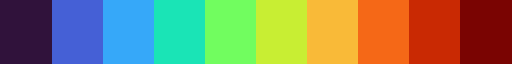

In [95]:
colors.ListedColormap(cmap(norm(np.linspace(0, 1, 10))))

In [106]:
def plotSED(zp, df, alpha=0.6, ms=50, save=False,
            save_dir='/Users/juliaroquette/Work/Plots/SED/'):
    """
    zp is the class zeropoints loaded, for example:
        zp = zeropoints()
    df is a dataframe containing lambdas, nuF_nu and uncertainties
    """
    lambda_key = '_lambda'
    nu_Fnu_key = '_nu_Fnu'
    error_key = 'error'
    lim_key = 'lim'
    # lim_nu_Fnu_values = []
    column = df.columns.to_list()
    nu_Fnu_values = np.array([df[item].to_list() for item in column if (nu_Fnu_key in item)
                     and (error_key not in item) and (lim_key not in item)]).reshape(-1)
    lambda_values =  np.array([df[item].to_list() for item in column if (lambda_key in item)]).reshape(-1)
    nu_Fnu_error_values =  np.array([df[item].to_list() for item in column if
                           (nu_Fnu_key in item) and (error_key in item) and
                           (lim_key not in item)]).reshape(-1)
    zp.get_survey_colours()
    colors = [zp.colors[name.split('_')[0]] for name in column if
              (lambda_key in name)]
    markers = [zp.markers[name.split('_')[0]] for name in column if
               (lambda_key in name)]
    label = [name.split('_')[0] for name in column if (lambda_key in name)]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
    ax.set_yscale("log")
    ax.set_xscale("log")
    is_ploted = []
    for lamb, nuFnu, co, mk, nm in zip(lambda_values, nu_Fnu_values,
                                       colors, markers, label):
        if nm in set(is_ploted):
            ax.scatter(lamb, nuFnu, color=co, cmap=plt.cm.turbo, marker=mk,
                       alpha=alpha, s=ms)
        else:
            ax.scatter(lamb, nuFnu, color=co, cmap=plt.cm.turbo, marker=mk,
                       alpha=alpha, label=nm, s=ms)
            is_ploted.append(nm)
    ax.plot(lambda_values[np.argsort(lambda_values)],
            nu_Fnu_values[np.argsort(lambda_values)],
            'k:', alpha=0.8, zorder=0)
    # print(lambda_values)
    # print(nu_Fnu_values)
    ax.set_xlabel(r'Wavelength - $\mu$m')
    ax.set_ylabel(r'$\nu F(\nu)$ - erg/s/$cm^2$/Hz')
    ax.set_title(f'SED for {df["Internal_ID"].iloc[0]}')
    ax.set_xticks([0.1, 1, 2, 5, 10, 20, 100, 500, 850])
    ax.set_xticklabels([0.1, 1, 2, 5, 10, 20, 100, 500, 850])
    ax.set_xlim(0.1, 1e4)
    ax.set_ylim(1e-16, 1e-5)
    ax.legend()
    if bool(save):
        plt.savefig(save_dir + 'SED_' + str(df["Internal_ID"].iloc[0]) +
                    '.png')
        plt.close(fig)
    else:
        plt.show()

# Converts fluxes to magnitudes:

$m=-2.5\log_{10}{\big(\frac{f}{f'}\big)},$
where $f'$ is the flux zeropoint. 

$\delta m=\frac{2.5}{\ln{10}}\frac{\delta_f}{f}$

$f = f'\times10^\frac{-m}{2.5}$

$m = m' + Ax$

$f = f'\times10^\frac{m' + Ax}{2.5} = f'\times10^\frac{m'}{2.5}10^\frac{Ax}{2.5}$


In [93]:
def flux2mag(flux, zeropoint, err_flux=np.nan):
    """
    Convert fluxes to magnitudes as:
    mag = -2.5*log10(flux/zeropoint)
    err_mag = 2.5*err_flux/flux/log(10)
    
    input:
        flux: in Jy
        err_flux: in Jy
        zeropoint: in Jy
    """
    if np.isfinite(err_flux):
        dm = 2.5*err_flux/np.log(10)/flux
    return -2.5*np.log10(flux/zeropoint), dm

In [94]:
def mag2flux(mag, zeropoint, err_mag=np.nan):
    """
    Convert magnitudes to fluxes as:
    flux = 10**(-mag/2.5)*zeropoint
    err_mag = zeropoint*ln(10)*10**(-mag/2.5)*err_mag/2.5
    
    input:
        mag: in mag
        err_mag: in mag
        zeropoint: in Jy
    """
    if np.isfinite(err_mag):
        df = zeropoint*np.log(10)*(10**(- mag/2.5))*err_mag/2.5
    return 10**(- mag/2.5)*zeropoint, df

In [95]:
def mag2flux(mag, zeropoint, err_mag=np.nan):
    """
    Convert magnitudes to fluxes as:
    flux = 10**(-mag/2.5)*zeropoint
    err_mag = zeropoint*ln(10)*10**(-mag/2.5)*err_mag/2.5
    
    input:
        mag: in mag
        err_mag: in mag
        zeropoint: in Jy
    """
    if np.isfinite(err_mag):
        df = zeropoint*np.log(10)*(10**(- mag/2.5))*err_mag/2.5
    return 10**(- mag/2.5)*zeropoint, df

In [111]:
def flux2nuFnu(lam_eff, flux, error, cgs=True):
    """
    Convert Fluxes to nuF_nu
    ___input___
    lam_eff -> Angstrom
    flux -> Jy
    ___output___
    nuF_nu in either cgs (if cgs=True) or W/m2
    """
    # Convert lambda eff to Angstrom
    lam_eff = lam_eff * u.Angstrom
    # Convert flux and uncertainty to Jansky
    flux = flux * u.Jy
    error = error * u.Jy
    # Calculate frequency
    freq = const.c / lam_eff
    # Convert flux and uncertainty to erg/s/cm/cm/Hz
    flux = flux.to(u.erg / (u.s * u.cm**2 * u.Hz))
    error = error.to(u.erg / (u.s * u.cm**2 * u.Hz))
    if bool(cgs):
        # Calculate nuF_nu in erg/s/cm/cm
        nuF_nu = (flux*freq).to(u.erg / u.s / u.cm**2)
        nuF_nu_error = (error*freq).to(u.erg / u.s / u.cm**2)
    else:
        # Calculate nuF_nu in W/m/m
        nuF_nu = (flux*freq).to(u.W / u.m**2)
        nuF_nu_error = (error*freq).to(u.W / u.m**2)
    # Return the nuF_nu values as a NumPy array
    return nuF_nu.value, nuF_nu_error.value


In [16]:
np.log10(1e-12)*(u.erg / u.s / u.cm**2 )/(1*u.micrometer.to(u.cm))

<Quantity -120000. erg / (cm2 s)>

In [ ]:
def nuFnu2lambdaFlambda(lam_eff, nuFnun, error, cgs=True):
    """
    Convert Fluxes to nuF_nu
    ___input___
    lam_eff -> Angstrom
    flux -> Jy
    ___output___
    nuF_nu in either cgs (if cgs=True) or W/m2
    """
    # Convert lambda eff to Angstrom
    lam_eff = lam_eff * u.Angstrom
    # Convert flux and uncertainty to Jansky
    flux = flux * u.Jy
    error = error * u.Jy
    # Calculate frequency
    freq = const.c / lam_eff
    # Convert flux and uncertainty to erg/s/cm/cm/Hz
    flux = flux.to(u.erg / (u.s * u.cm**2 * u.Hz))
    error = error.to(u.erg / (u.s * u.cm**2 * u.Hz))
    if bool(cgs):
        # Calculate nuF_nu in erg/s/cm/cm
        nuF_nu = (flux*freq).to(u.erg / u.s / u.cm**2)
        nuF_nu_error = (error*freq).to(u.erg / u.s / u.cm**2)
    else:
        # Calculate nuF_nu in W/m/m
        nuF_nu = (flux*freq).to(u.W / u.m**2)
        nuF_nu_error = (error*freq).to(u.W / u.m**2)
    # Return the nuF_nu values as a NumPy array
    return nuF_nu.value, nuF_nu_error.value


In [113]:
flux2nuFnu(lambda_eff['twomass_J'], [1,2], [0.1, 0.2], cgs=True)

(array([2.42746930e-09, 4.85493859e-09]),
 array([2.42746930e-10, 4.85493859e-10]))

In [117]:
def plotSED(zp, df, alpha=0.6, ms=50, save=False,
            save_dir='/Users/juliaroquette/Work/Plots/SED/'):
    """
    zp is the class zeropoints loaded, for example:
        zp = zeropoints()
    df is a dataframe containing lambdas, nuF_nu and uncertainties
    """
    lambda_key = 'lambda'
    nu_Fnu_key = 'nu_Fnu'
    error_key = 'error'
    lim_key = 'lim'
    # lim_nu_Fnu_values = []
    column = df.columns.to_list()
    nu_Fnu_values = np.array([df[item].to_list() for item in column if
                              (nu_Fnu_key in item) and (error_key not in item)
                              and (lim_key not in item)]).reshape(-1)
    lambda_values =  np.array([df[item].to_list() for item in column if
                               (lambda_key in item) and
                               (lim_key not in item)]).reshape(-1)
    nu_Fnu_error_values =  np.array([df[item].to_list() for item in column if
                                     (nu_Fnu_key in item) and
                                     (error_key in item) and
                                     (lim_key not in item)]).reshape(-1)
    zp.get_survey_colours()
    colors = [zp.colors[name.split('_')[0]] for name in column if
              (lambda_key in name)]
    markers = [zp.markers[name.split('_')[0]] for name in column if
               (lambda_key in name)]
    label = [name.split('_')[0] for name in column if (lambda_key in name)]
    #
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
    #
    plt.subplots_adjust(left=0.1, bottom=0.14, right=0.6, top=0.92)
    ax.set_yscale("log")
    ax.set_xscale("log")
    is_ploted = []
    for lamb, nuFnu, co, mk, nm in zip(lambda_values, nu_Fnu_values,
                                       colors, markers, label):
        if nm in set(is_ploted):
            ax.scatter(lamb, nuFnu, color=co, cmap=plt.cm.turbo, marker=mk,
                       alpha=alpha, s=ms)
        else:
            if np.isfinite(nuFnu):
                ax.scatter(lamb, nuFnu, color=co, cmap=plt.cm.turbo, marker=mk,
                           alpha=alpha, label=nm, s=ms)
            is_ploted.append(nm)
    ax.plot(lambda_values[np.argsort(lambda_values)],
            nu_Fnu_values[np.argsort(lambda_values)],
            'k:', alpha=0.8, zorder=0)
    # print(lambda_values)
    # print(nu_Fnu_values)
    ax.set_xlabel(r'Wavelength - $\mu$m')
    ax.set_ylabel(r'$\nu F(\nu)$ - erg/s/$cm^2$')
    ax.set_title(f'SED for {df["Internal_ID"].iloc[0]}')
    ax.set_xticks([0.1, 1, 2, 5, 10, 20, 100, 500, 850])
    ax.set_xticklabels([0.1, 1, 2, 5, 10, 20, 100, 500, 850])
    ax.set_xlim(0.1, 1e4)
    ax.set_ylim(1e-16, 1e-5)
    ax.legend(ncol=3, bbox_to_anchor=(1.8, 1.))
    if bool(save):
        plt.savefig(save_dir + 'SED_' + str(df["Internal_ID"].iloc[0]) +
                    '.png')
        plt.close(fig)
    else:
        plt.show()

In [ ]:
import pandas as pd


# Keywords for column selectio


print("Lambda:", lambda_values)
print("nu_Fnu:", nu_Fnu_values)
print("nu_Fnu_error:", nu_Fnu_error_values)
print("lim_nu_Fnu_error:", lim_nu_Fnu_error_values)
print("lim_nu_Fnu:", lim_nu_Fnu_values)
